# **Категоризация товаров**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import string

In [ ]:
% matplotlib inline
pd.options.mode.chained_assignment = None

In [ ]:
!pip install pyarrow

# Работа с датасетом

In [ ]:
train_df = pd.read_parquet('train.parquet')
cat_df = pd.read_csv('categories_tree.csv')

In [ ]:
#Первый взгляд на загруженные данные
display(train_df.head())
cat_df.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity,category_id
0,1267423,Muhle Manikure Песочные колпачки для педикюра ...,Muhle Manikure Колпачок песочный шлифовальный ...,None,0.000000,0,2693
1,128833,"Sony Xperia L1 Защитное стекло 2,5D",None,None,4.666667,9,13408
2,569924,"Конверт для денег Прекрасная роза, 16,5 х 8 см","Конверт для денег «Прекрасная роза», 16,5 × 8 см",None,5.000000,6,11790
3,1264824,Серьги,None,None,0.000000,0,14076
4,1339052,Наклейки на унитаз для туалета на крышку бачок...,"Водостойкая, интересная наклейка на унитаз раз...",None,0.000000,0,12401


,id,title,parent_id
0,1,Все категории,0
1,114,Урбеч,1913
2,115,Варенье и джемы,328
3,128,Сухие завтраки,2475
4,131,Масла,2475


In [ ]:
print(train_df.shape)
print(cat_df.shape)

(283452, 7)
(3364, 3)


In [ ]:
#Создадим общую табличку и проанализируем важность колонок для категоризации
merged_df = train_df.merge(cat_df, how='inner', left_on='category_id', right_on='id')
merged_df = merged_df.drop('id_y', axis=1)
col_map = {'id_x': 'id', 'title_x': 'item_title', 'title_y': 'cat_title', 'parent_id': 'cat_parent'}
merged_df = merged_df.rename(columns=col_map)

In [ ]:
merged_df.sample(5)

,id,item_title,short_description,name_value_characteristics,rating,feedback_quantity,category_id,cat_title,cat_parent
228560,576813,Набор бутылочек 3шт 200мл 1шт 80мл,"Заполняйте флаконы Вашими любимыми кремами, ша...",None,0.0,0,13201,Флаконы дорожные,11449
276885,1026370,Зарядное устройство Relato CH-P1640U/LP-E8/ дл...,Необычайно компактное и лёгкое зарядное устрой...,None,0.0,0,12843,Зарядные устройства,10765
199212,1311873,"Belor Design Подводка для бровей Color Brow ,...",Belor Design Подводка для бровей Color Brow,None,0.0,0,11984,"Туши, тени, гели, помады для бровей",11015
39460,473976,Silicone Case Чехлы для Iphone XS MAX,None,None,0.0,0,11937,Чехлы,10398
72101,1310241,Резинка-пружинка для волос,Яркая резинка-пружинка для волос,None,0.0,0,12751,Резинки,10152


**Колонки и их потенциальная важность**

*   **id** - идентификатор самого товара, не несет важной информации, так как уникален для каждого объекта и не связан с другими элементами таблицы.
*   **item_tile** - название товара, используемое для презентации и поиска карточки товара. Исходя из своих целей должно содержать ключевые слова и некоторое описание.
*   **short_description** - короткое описание товара, не обязательно содержит ключевые слова. Но может добавлять полезную информацию более точно указывающую на категорию.
*   **name_value_characteristics** - редко встречающееся поле с характеристиками. Не несет полезной для категоризации информации, так как разные товары могут разделять одинаковые характеристики (размер, цвет и т.д.)
*   **rating и feedback_quantity** - оценка товара пользователем и количество оценок. Характеристики, которые можно использовать при рекомендации, но так как категоризация товара происходит во время его размещения, для нас указанные столбцы не важны.
*   **category_id**	- собственно номер категории, который мы и должны будем выяснить в данных для предикта.


Исходя из таблицы категорий, каждой узкой категории соответствует более широкая категория-родитель. Используя прямое соответствие мы без проблем выберем категорию-родителя.





**Постановка задачи**

На основе изученных данных мы можем выявить, что наиболее важную информацию мы получаем из текстовой колонки item_title, но также улучшить метрику нам поможет колонка short_description

Таким образом, задача следующая:

1.   Подготовить датасет из item_title + short_description / category_id
2.   Создать языковую модель, обученную на подготовленных данных
3.   Предсказать узкие категории для тестовых данных
4.   Радоваться :)





# Подготовка данных

*Дальнейшие действия для экономии времени можно не выполнять, сохраненный и подготовленный датасет можно загрузить в одном из блоков ниже*

In [ ]:
# Объединим колонки с полезной информацией
merged_df['item_title'] = merged_df['item_title'].astype(str) + ' ' + merged_df['short_description'].astype(str)

In [ ]:
df = merged_df[['item_title', 'category_id']]

In [ ]:
print(f'Отсутствуют данные:\n{df.isna().sum()}\n')
print(f'Количество дубликатов:\n{df.duplicated().sum()}')

Отсутствуют данные:
item_title     0
category_id    0
dtype: int64

Количество дубликатов:
28227


In [ ]:
# Так как размер датасета достаточно большой
# строки с пропущенными значениями и дубликаты 
# на данном этапе можно удалить

df = df.dropna()
df = df.drop_duplicates()

In [ ]:
print(f'Отсутствуют данные:\n{df.isna().sum()}\n')
print(f'Количество дубликатов:\n{df.duplicated().sum()}')

Отсутствуют данные:
item_title     0
category_id    0
dtype: int64

Количество дубликатов:
0


In [ ]:
#Создадим функции для подготовки текстовых данных: 
    # - Уберем латиницу и цифры, так как зачастую это названия брендов и количество/размер, 
    # - Приведем все к нижнему регистру  

def text_cleaning(df, title):
    r = re.compile("[a-zA-Z0-9]+\s|[a-zA-Z0-9]")

    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        text = row[title]
        text = re.sub(r, ' ', text)
        text = text.translate(str.maketrans(' ', ' ', string.punctuation))
        text = text.lower()
        df.loc[idx, title] = text
        

In [ ]:
text_cleaning(df, 'item_title')

100%|██████████| 254814/254814 [1:50:38<00:00, 38.38it/s]


In [ ]:
# Сохранение и загрузка очищенного датасета

# df.to_csv('df_cleaned.csv', index=False)

df = pd.read_csv('df_cleaned.csv')

Теперь проверим количество лейблов в получившемся датасете, а самое главное - их распределение. Также построим гистограмму по количеству категорий (эмпирически возьмем до 100 штук)

In [ ]:
print(f"Уникальных категорий - {df['category_id'].nunique()}")
df['category_id'].value_counts()

Уникальных категорий - 1229


11937    14263
13408     7066
13061     5572
13143     5300
13407     3102
         ...  
13886        2
11891        2
14072        2
13631        2
13675        1
Name: category_id, Length: 1229, dtype: int64

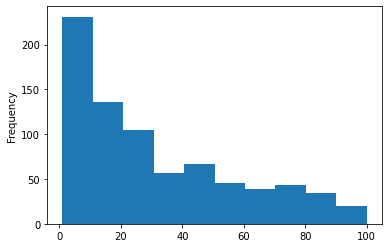

In [ ]:
df['category_id'].value_counts().plot(kind='hist', range=(1, 100))

Видим неприятную ситуацию: очень большое количество классов содержится в датасете в количестве до 100. 
К чему это может привести? К тому, что при разделение на тренировочную и валидационную выборку какие-то классы не попадут в одну из выборок. Используем простейший ресемплинг: будет дублировать классы, которые находятся в минимальном количестве, до тех пор пока таких классов не останется.

In [ ]:
# Логика такая: 
    # отбираем номера классов, которых меньше чем min_count
    # из df достаем все строки соответствующие этим классам
    # дублируем этот мини-датафрейм
    # прибавляем результат к основному
    # повторяем пока не закончатся классы с кол-вом меньше min_count


def oversampling(df, min_count):
    df_vc = df
    while df_vc.shape[0] > 0:
        df_vc = df['category_id'].value_counts().loc[lambda x: x < min_count].reset_index()['index']
        df_minority = df[df['category_id'].isin(df_vc)]
        df_minority = df_minority.append(df_minority)
        df = df.append(df_minority)
    return df

In [ ]:
# Несмотря на то, что мы строили гистограмму до 100 штук, для обучения должно хватить даже 50, поэтому оверсемплинг будем делать до этого количества.

print(f'Размер до ресемплинга: {df.shape}')
df = oversampling(df, 50)
print(f'Размер после ресемплинга: {df.shape}')

Размер до ресемплинга: (254814, 2)
Размер после ресемплинга: (297698, 2)


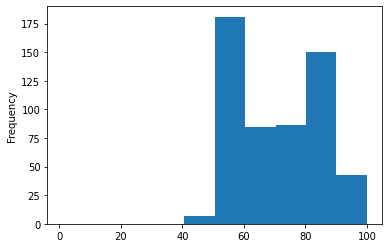

In [ ]:
df['category_id'].value_counts().plot(kind='hist', range=(1, 100))

Сохраним результат всех операций для повторного использования

# Создание языковой модели

Займемся созданием самой модели. А точнее даже дообучением, поскольку в качестве базы будем использовать всеми любимый BERT.
Для нашей задачи идеально подойдет [DeepPavlov/rubert-base-cased](https://huggingface.co/DeepPavlov/rubert-base-cased)

In [ ]:
!pip install transformers

In [ ]:
import os
import time
import datetime
import random
from sklearn.metrics import f1_score

from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import AdamW
from transformers import AutoTokenizer
from transformers import get_linear_schedule_with_warmup

import torch
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
# Проверим доступность GPU

torch.cuda.empty_cache()

if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('Доступных видеокарт: %d.' % torch.cuda.device_count())

    print('Будет использоваться:', torch.cuda.get_device_name(0))

else:
    print('Нет доступных GPU, используется CPU.')
    device = torch.device("cpu")

Доступных видеокарт: 1.
Будет использоваться: Tesla K80


In [ ]:
texts = df.item_title.values
label_cats = df.category_id.astype('category').cat

# Список категорий
label_names = label_cats.categories

# Список id всех категорий (от 0 в порядке возрастания)
labels = label_cats.codes

In [ ]:
model_name = "DeepPavlov/rubert-base-cased"

In [ ]:
#Загружаем токенизатор
print(f"Загружается {model_name} tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)

Загружается DeepPavlov/rubert-base-cased tokenizer...


Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Токенизируем все названия и привязываем токены к id слов
input_ids = []
attention_masks = []

for text in tqdm(texts, total=len(texts)):
    encoded_dict = tokenizer.encode_plus(
                        text,            
                        add_special_tokens = True,
                        max_length = 120,
                        padding='max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt')
  
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

100%|██████████| 297698/297698 [01:33<00:00, 3197.83it/s]


In [ ]:
# Переводим нужные списки в тензоры 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

In [ ]:
# Создаем датасет из полученных наборов тензоров
dataset = TensorDataset(input_ids, attention_masks, labels)


# Делим датасет на 3 части в соотношении 80-10-10 для обучения и проверки
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset)) 
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"{train_size} семплов в трейне")
print(f"{val_size} семплов в валидации")
print(f"{test_size} семплов в тесте")

238158 семплов в трейне
29769 семплов в валидации
29771 семплов в тесте


Теперь создадим DataLoader'ы для подачи данных батчами. Размер батча (32) выбран на основе некоторого количество проведенных циклов обучения. Вполне возможно, что уменьшение количества до 16 улучшило бы качество предсказаний, однако упираемся в ограничение арендованного GPU по времени работы :(

In [ ]:
batch_size = 32


# Создадим класс DataLoader для передачи батчей
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = batch_size
        )

In [ ]:
# Загружаем модель для классификации
print(f"Загружается {model_name}...")
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(label_names)
config.output_attentions = True
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config)


model.cuda()

In [ ]:
# Выбираем оптимизатор и его параметры
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                )

/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Установим количество эпох. Возьмем 4, поскольку опытным путем выявлено,
# что после 4й эпохи лосс на валидации начинает снова расти

epochs = 4

total_steps = len(train_dataloader) * epochs

# Создадим learning rate scheduler для подгонки lr в процессе обучения
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# Небольшая функция для расчета метрики в процессе валидации
def flat_f1(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, pred_flat, average='micro')

In [ ]:
# Функция, которая нам будет полезна при расчете затраченного времени
def format_time(elapsed):
    '''
    Переводит время в секундах в формат hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# Процесс тренировки

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Здесь будем хранить значения, полученные в процессе обучения (лоссы, метрику)
training_stats = []

total_t0 = time.time()


for epoch_i in range(0, epochs):

    # ========================================
    #               Обучение
    # ========================================

    print("")
    print('======== Эпоха {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Обучение...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        # Отмечает прогресс каждые 200 батчей.
        if step % 200 == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Батч {:>5,}  из  {:>5,}.    Прошло: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits, attentions = model(input_ids=b_input_ids, 
                                         attention_mask=b_input_mask, 
                                         labels=b_labels, return_dict=False)

        total_train_loss += loss.item()

        loss.backward()

        # Ограничение значений. Поможет избавиться от взрывающегося градиента
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Средний лосс на обучении: {0:.2f}".format(avg_train_loss))
    print("  На эпоху потрачено: {:}".format(training_time))
        
    # ========================================
    #               Валидация
    # ========================================

    print("")
    print("Валидация...")

    t0 = time.time()

    model.eval()

    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            (loss, logits, attentions) = model(input_ids=b_input_ids, 
                                               attention_mask=b_input_mask,
                                               labels=b_labels, return_dict=False)            

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_f1 += flat_f1(logits, label_ids)
        

    # Средняя F-мера на валидации
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    print("  F1-мера: {0:.2f}".format(avg_val_f1))

    # Средний лосс по батчам
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Время затраченное на валидацию
    validation_time = format_time(time.time() - t0)
    
    print("  Средний лосс на валидации: {0:.2f}".format(avg_val_loss))
    print("  На валидацию потрачено: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. F1.': avg_val_f1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Обучение завершено!")

print("Общее время обучения модели {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Эпоха 1 / 4 ========
Обучение...
  Батч   200  из  7,443.    Прошло: 0:01:37.
  Батч   400  из  7,443.    Прошло: 0:03:13.
  Батч   600  из  7,443.    Прошло: 0:04:50.
  Батч   800  из  7,443.    Прошло: 0:06:27.
  Батч 1,000  из  7,443.    Прошло: 0:08:04.
  Батч 1,200  из  7,443.    Прошло: 0:09:40.
  Батч 1,400  из  7,443.    Прошло: 0:11:17.
  Батч 1,600  из  7,443.    Прошло: 0:12:54.
  Батч 1,800  из  7,443.    Прошло: 0:14:30.
  Батч 2,000  из  7,443.    Прошло: 0:16:07.
  Батч 2,200  из  7,443.    Прошло: 0:17:44.
  Батч 2,400  из  7,443.    Прошло: 0:19:21.
  Батч 2,600  из  7,443.    Прошло: 0:20:57.
  Батч 2,800  из  7,443.    Прошло: 0:22:34.
  Батч 3,000  из  7,443.    Прошло: 0:24:11.
  Батч 3,200  из  7,443.    Прошло: 0:25:47.
  Батч 3,400  из  7,443.    Прошло: 0:27:24.
  Батч 3,600  из  7,443.    Прошло: 0:29:01.
  Батч 3,800  из  7,443.    Прошло: 0:30:38.
  Батч 4,000  из  7,443.    Прошло: 0:32:14.
  Батч 4,200  из  7,443.    Прошло: 0:33:51.
  Батч 4,400

# Проверка процесса обучения

In [ ]:
# Создадим сравнительную таблицу по эпохам

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,Training Loss,Valid. Loss,Valid. F1.,Training Time,Validation Time
epoch,,,,,
1,2.90,1.53,0.71,0:59:59,0:02:21
2,1.16,0.90,0.81,0:59:57,0:02:21
3,0.74,0.71,0.84,0:59:58,0:02:21
4,0.58,0.66,0.85,0:59:58,0:02:21


Окончательная проверка на тест-сете

In [ ]:
print("Предсказываем категории ...")

model.eval()

predictions, true_labels = [], []

for batch in test_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
          outputs = model(input_ids=b_input_ids,
                          attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.extend(logits)
    true_labels.extend(label_ids)

print(f"Предсказано {len(predictions)} сэмплов")

Предсказываем категории ...
Предсказано 29771 сэмплов


In [ ]:
predictions = np.argmax(predictions, axis=1)
true_labels = np.array(true_labels)
print(f"F-мера на тест-сете: {f1_score(true_labels, predictions, average='micro')}")

F-мера на тест-сете: 0.8468979879748748


In [ ]:
pred = []
true_lbl = []
for i in tqdm(predictions):
    pred.append(label_names[i])
for i in tqdm(true_labels):
    true_lbl.append(label_names[i])

100%|██████████| 29771/29771 [00:00<00:00, 533403.21it/s]


Создадим небольшой датафрейм и визуально оценим качество предсказаний

In [ ]:
df3 = pd.DataFrame(data={'true_label': true_lbl, 'pred': pred})
df3 = df3.merge(cat_df, how='left', left_on='true_label', right_on='id')
df3 = df3.merge(cat_df, how='left', left_on='pred', right_on='id')

In [ ]:
df3.sample(10)

,true_label,pred,id_x,title_x,parent_id_x,id_y,title_y,parent_id_y
19450,11937,11937,11937,Чехлы,10398,11937,Чехлы,10398
25450,12454,12454,12454,Дизайн ногтей,10113,12454,Дизайн ногтей,10113
27715,2663,2663,2663,Скрабы и пилинг,10137,2663,Скрабы и пилинг,10137
10843,12084,12084,12084,Религиозная одежда,10014,12084,Религиозная одежда,10014
7202,2599,2599,2599,Купальники,11351,2599,Купальники,11351
29159,13046,13046,13046,Эмульсии и эликсиры,10918,13046,Эмульсии и эликсиры,10918
17795,13901,13901,13901,Емкости для специй и мельницы,10992,13901,Емкости для специй и мельницы,10992
13118,12665,12665,12665,Чехлы и кейсы,10765,12665,Чехлы и кейсы,10765
17005,14065,14065,14065,Зарядные устройства для аккумуляторов,10073,14065,Зарядные устройства для аккумуляторов,10073
28461,13408,13408,13408,Защитные стекла и пленки,10398,13408,Защитные стекла и пленки,10398


Выглядит достаточно хорошо :)

Теперь создадим функцию для высчитывания приблизительной иерархической F-меры. Сделаем допущение, что каждый объект мы сравниваем именно с его true path, поэтому Ti = 2.

In [ ]:
def hF1_custom(df, true, parent_true, pred, parent_pred):
    df['Pi'] = 0
    df.loc[df[true] == df[pred], 'Pi'] = 2
    df.loc[(df[true] != df[pred])&(df[parent_true] == df[parent_pred]), 'Pi'] = 1
    df['Ti'] = 2
    df['Ti Pi'] = df3[['Ti','Pi']].min(axis=1)
    hP = df['Ti Pi'].sum()/df['Pi'].sum()
    hR = df['Ti Pi'].sum()/df['Ti'].sum()
    hF = (2 * hP * hR)/(hP + hR)
    return hF

In [ ]:
hF = hF1_custom(df3, 'id_x', 'parent_id_x', 'id_y', 'parent_id_y')
print(f'Кастомная иерархическая F-мера: {hF}')

Кастомная иерархическая F-мера: 0.9272291587842098


# Сохранение модели

In [ ]:
# Сохраним модель в директорию с полным названием модели, 
#     для более удобного импорта с помощью from_pretrained

output_dir = f"./{model_name}/"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Сохранение в {output_dir}")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Сохранение в ./DeepPavlov/rubert-base-cased/


('./DeepPavlov/rubert-base-cased/tokenizer_config.json',
 './DeepPavlov/rubert-base-cased/special_tokens_map.json',
 './DeepPavlov/rubert-base-cased/vocab.txt',
 './DeepPavlov/rubert-base-cased/added_tokens.json',
 './DeepPavlov/rubert-base-cased/tokenizer.json')

# Загрузка модели

In [ ]:
input_dir = f"./{model_name}/"

model = AutoModelForSequenceClassification.from_pretrained(input_dir)
tokenizer = AutoTokenizer.from_pretrained(input_dir)

model.to(device)

# Предсказание

Подготовим датасет аналогично тому, как готовили тренировочный

In [ ]:
to_predict = pd.read_parquet('test.parquet')
to_predict.shape

(70864, 6)

In [ ]:
to_predict.head()

,id,title,short_description,name_value_characteristics,rating,feedback_quantity
0,1070974,Браслет из натуральных камней LOTUS,None,None,0.000000,0
1,450413,Fusion Life - Шампунь для сухих и окрашенных в...,None,None,4.333333,6
2,126857,"Микрофон для ПК jack 3,5мм всенаправленный","универсальный 3,5 мм микрофон запишет ваш звук",None,3.708333,24
3,1577569,Серьги гвоздики сердце,Серьги гвоздики сердце,None,0.000000,0
4,869328,"Чёрно-красная стильная брошь ""Тюльпаны"" из акр...",Стильная и яркая брошь ручной работы! Великоле...,None,0.000000,0


In [ ]:
to_predict['title'] = to_predict['title'].astype(str) + ' ' + to_predict['short_description'].astype(str)

In [ ]:
text_cleaning(to_predict, 'title')

100%|██████████| 70864/70864 [03:21<00:00, 351.80it/s]


Токенизируем значения и создадим DataLoader

In [ ]:
texts = to_predict.title.values

In [ ]:
input_ids = []
attention_masks = []

for text in tqdm(texts, total=len(texts)):
    encoded_dict = tokenizer.encode_plus(
                          text,            
                          add_special_tokens = True,
                          max_length = 120,
                          padding='max_length',
                          return_attention_mask = True,
                          return_tensors = 'pt')
    
    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

100%|██████████| 70864/70864 [00:21<00:00, 3296.69it/s]


In [ ]:
predict_dataset = TensorDataset(input_ids, attention_masks)

predict_dataloader = DataLoader(
            predict_dataset,
            sampler = SequentialSampler(predict_dataset),
            batch_size = 128
        )

Производим предикт с помощью нашей обученной модели, только с переключением ее в режим eval и без вычисления градиента.

In [ ]:
model.eval()

predictions = []

for batch in predict_dataloader:

    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask = batch

    with torch.no_grad():
          outputs = model(input_ids=b_input_ids,
                          attention_mask=b_input_mask)

    logits = outputs[0]

    logits = logits.detach().cpu().numpy()

    predictions.extend(logits)


In [ ]:
pred_labels = []
for i in tqdm(predictions):
    pred_idx = np.argmax(i)
    pred_labels.append(label_names[pred_idx])

100%|██████████| 70864/70864 [00:00<00:00, 191261.38it/s]


Теперь настало время собрать сводную таблицу по предсказанным классом и посмотреть, что получилось

In [ ]:
to_predict['category_id'] = pred_labels

In [ ]:
merged_test = to_predict.merge(cat_df, how='left', left_on='category_id', right_on='id')
merged_test = merged_test.drop(['id_y', 'short_description', 'name_value_characteristics', 'rating', 'feedback_quantity'], axis=1)
col_map = {'id_x': 'id', 'title_x': 'item_title', 'title_y': 'cat_title', 'parent_id': 'cat_parent', 'category_id': 'predicted_category_id'}
merged_test = merged_test.rename(columns=col_map)

merged_test.head()

,id,item_title,predicted_category_id,cat_title,cat_parent
0,1070974,браслет из натуральных камней,11574,Браслеты,10104
1,450413,шампунь для сухих и окрашенных волос личи ...,11878,Шампуни,10705
2,126857,микрофон для пк мм всенаправленный универса...,13299,Микрофоны,10374
3,1577569,серьги гвоздики сердце серьги гвоздики сердце,13061,Серьги,10104
4,869328,чёрнокрасная стильная брошь тюльпаны из акрила...,12813,Броши,10104


In [ ]:
# Дополнительно просмотрим рандомные семплы

merged_test.sample(20)

,id,item_title,predicted_category_id,cat_title,cat_parent
38135,796677,тоника оттеночный бальзам для тонирования вол...,12616,Оттеночные и тонирующие средства,11285
9433,1491396,браслет из натурального камня амазонита брасле...,11574,Браслеты,10104
17722,938043,электрогирлянда ламп м электрогирлянда элект...,13495,Гирлянды,10508
4942,321312,боди,12415,Боди и комбинезоны,10095
59226,1248940,детский браслет мишки,12434,Браслеты,10160
11492,1142820,зарядка для айфона кабель для зарядки ...,12171,Кабели,11281
1726,1160416,вращающаяся подставка для торта см вращающаяс...,11896,Блюда,10377
54041,1227051,молочко для тела тонизирующее спорт и фитнес...,12882,Лосьоны и молочко,10918
54526,1387357,комплект сетчатого нижнего белья с бантиком ко...,12657,Комплекты белья,11351
31470,1562653,крем от натоптышей мл крем от натоптышей...,14113,Кремы для ног,10918


Результаты выглядят очень неплохо. Настало время сохранить их в result.parquet

In [ ]:
result = merged_test[['id', 'predicted_category_id']]
result.head()

,id,predicted_category_id
0,1070974,11574
1,450413,11878
2,126857,13299
3,1577569,13061
4,869328,12813


In [ ]:
result.to_parquet('result.parquet', index=False)